<a href="https://colab.research.google.com/github/PsorTheDoctor/deep-neural-nets/blob/main/week8_antoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Auto Encoder



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions.normal import Normal
import torchvision
from tqdm.notebook import tqdm
from scipy import ndimage
# from google_drive_downloader import GoogleDriveDownloader as gdd

## Load FaceScrub data

In [ ]:
# gdd.download_file_from_google_drive('1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk', '~/img_align_celeba_50k.npz')
!gdown 'https://drive.google.com/uc?id=1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk'
blob = np.load('/content/img_align_celeba_50k.npz')
x_train, x_test = blob['x_train'], blob['x_test']
dim = x_train.shape[1:]
n_valid = 2000
x_train, x_valid = x_train[:-n_valid], x_train[-n_valid:]

print(f'x_train shape: {x_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'dtype: {x_train.dtype}')

In [ ]:
def noise(array):
    noise_factor = 0.1
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 1.0).astype(array.dtype)

x_train_noised = noise(x_train)
x_valid_noised = noise(x_valid)

## Now lets visualize our original and corrupted data

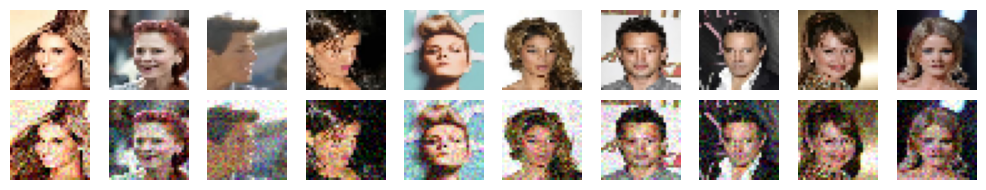

In [ ]:
def plot_rows(*img_rows, scale=1.):
    rows = len(img_rows)
    cols = len(img_rows[0])
    fig, axs = plt.subplots(rows, cols, figsize=(cols * scale, rows * scale))
    for i, img_row in enumerate(img_rows):
        for j, im in enumerate(img_row):
            ax = axs[i, j]
            ax.imshow(np.clip(im, 0, 1))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_rows(x_train[:10], x_train_noised[:10])

## Normalizing the data

In [ ]:
mu, std = np.mean(x_train, axis=(0, 1, 2)), np.std(x_train, axis=(0, 1, 2))
print("mu: ", mu, " sigma: ", std)

def norm(a):
    return torch.from_numpy((a - mu) / std).permute(0, 3, 1, 2)

def denorm(a):
    return a.detach().cpu().permute(0, 2, 3, 1).numpy() * std + mu

x_train_normed = norm(x_train)
x_valid_normed = norm(x_valid)
x_train_noised_normed = norm(x_train_noised)
x_valid_noised_normed = norm(x_valid_noised)

mu:  [0.34133333 0.34133333 0.34133333]  sigma:  [0.32654327 0.27426648 0.2628333 ]


## Now build you de-nosing auto-encoder model

Tip:
* Its better to use over-complete auto-encoder (i.e latent represent is of higher dimensionality than the input)
* You will need to use transposed convolution in decoder (check torch ConvTranspose2d)
* You can start with 2 convolutional layers each for encoder & decoder

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size),
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        x = self.decoder(x)
        return x.view(-1, 3, 32, 32)

    def forward(self, x):
        return self.decode(self.encode(x))

## Loading data for training

In [ ]:
train_data = list(zip(x_train_noised_normed, x_train_normed))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)

valid_data = list(zip(x_valid_noised_normed, x_valid_normed))
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Now lets train the auto-encoder

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, mse loss (train/valid): 0.1425/0.0644
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


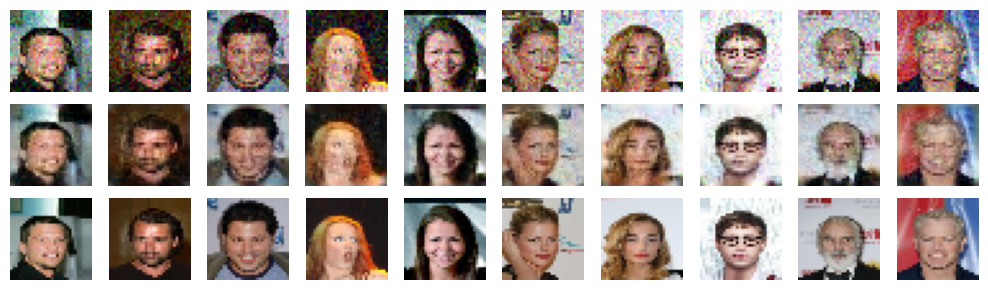

epoch: 1, mse loss (train/valid): 0.0575/0.0537
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


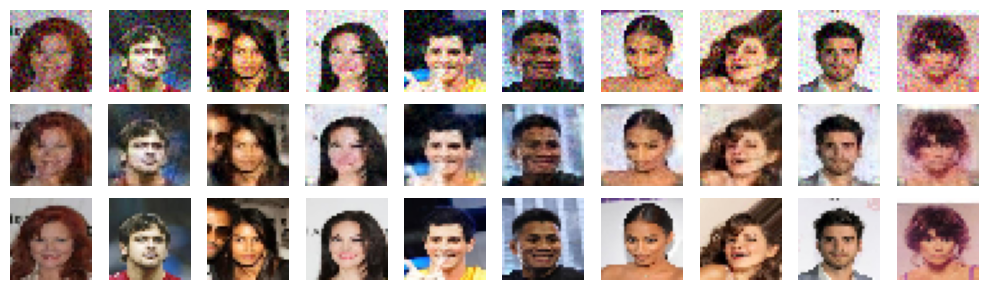

epoch: 2, mse loss (train/valid): 0.0495/0.0544
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


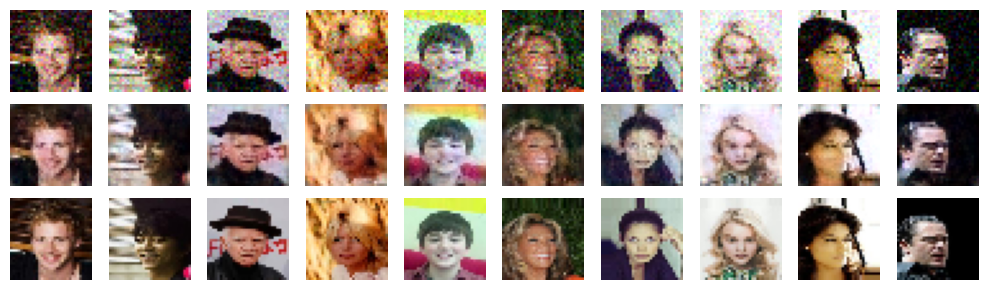

epoch: 3, mse loss (train/valid): 0.0450/0.0458
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


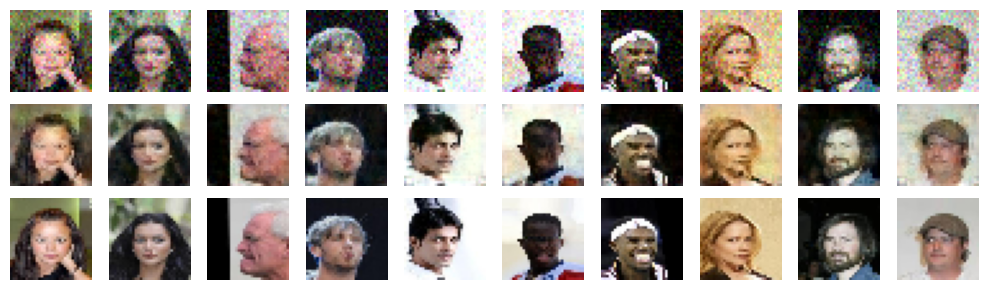

epoch: 4, mse loss (train/valid): 0.0418/0.0410
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


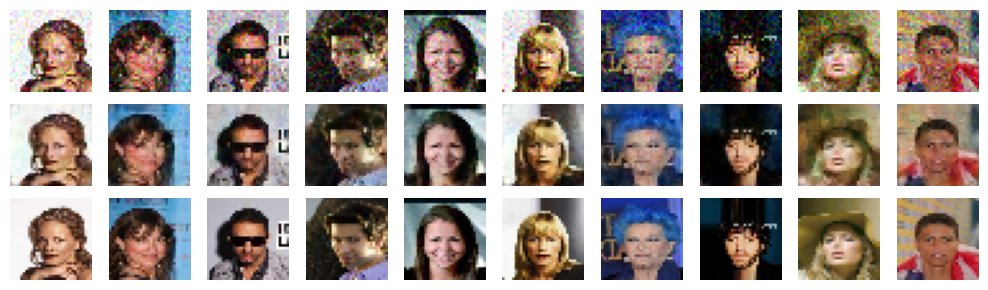

epoch: 5, mse loss (train/valid): 0.0395/0.0400
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


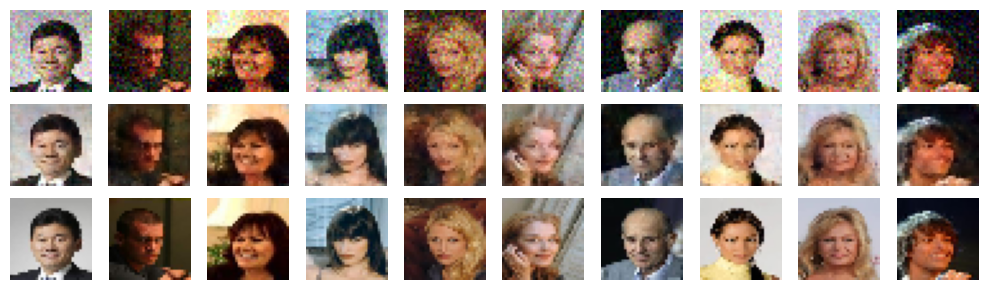

epoch: 6, mse loss (train/valid): 0.0380/0.0391
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


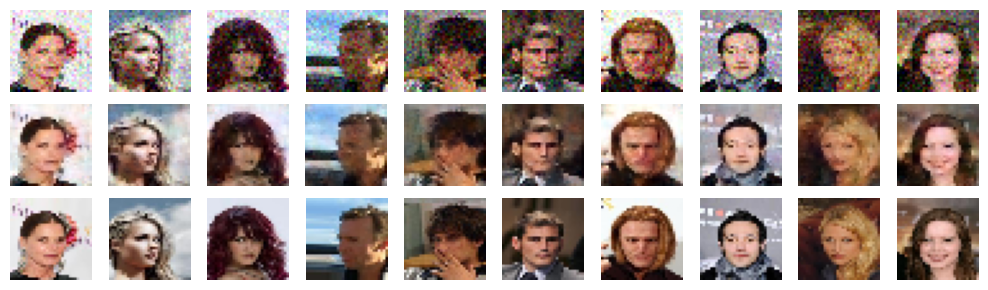

epoch: 7, mse loss (train/valid): 0.0368/0.0361
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


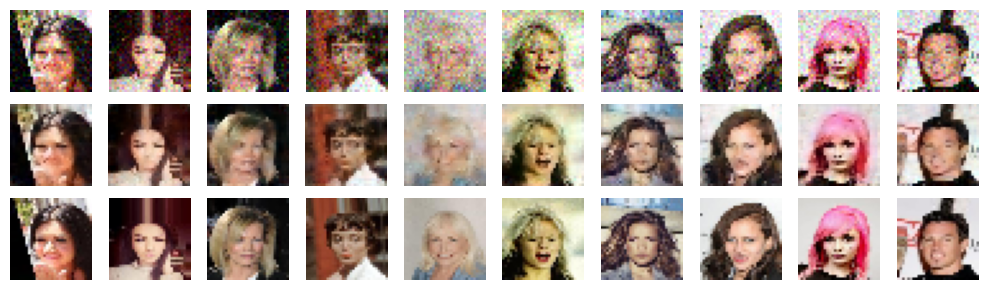

epoch: 8, mse loss (train/valid): 0.0359/0.0355
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


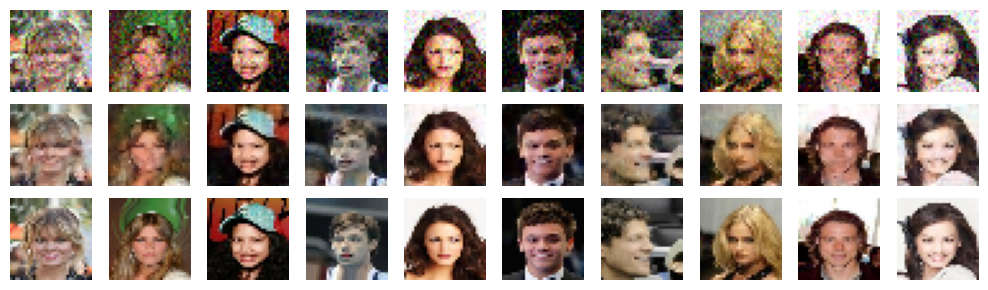

epoch: 9, mse loss (train/valid): 0.0349/0.0359
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


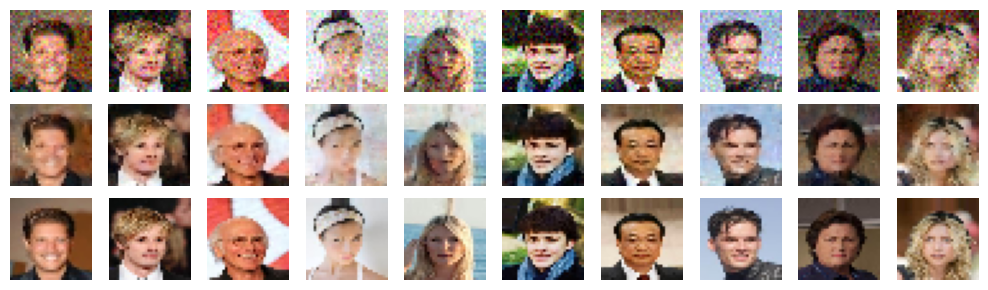

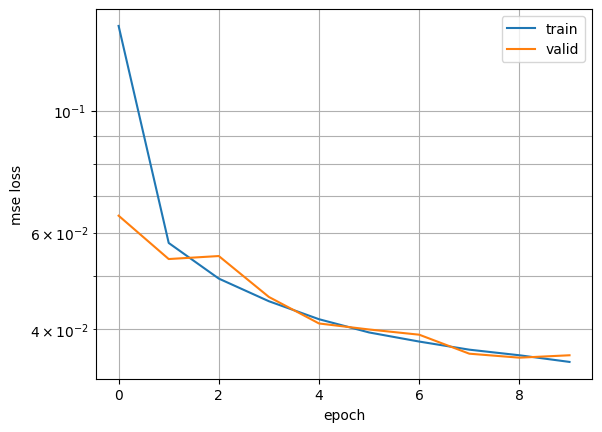

In [ ]:
model = AutoEncoder().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
valid_losses = []

for epoch in tqdm(range(10)):
    losses = []
    for x, y in train_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    train_losses.append(np.mean(losses))

    losses = []
    for x, y in valid_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)
        losses.append(loss.item())
    valid_losses.append(np.mean(losses))

    print(f'epoch: {epoch}, mse loss (train/valid): {train_losses[-1]:.4f}/{valid_losses[-1]:.4f}')
    print('Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)')
    plot_rows(denorm(x[:10]), denorm(y_hat[:10]), denorm(y[:10]), scale=1)

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.grid(which='both')
plt.legend()
plt.show()

# Bonus: Variational Auto Encoder


## Load MNIST data

In [ ]:
mnist = torchvision.datasets.MNIST('~/data', download=True)
print(mnist.data.shape)
print(mnist.targets.shape)

## Normalize data

In [4]:
data = mnist.data.view(-1, 28 * 28).float() / 255
mu, std = data.mean(), data.std()
data = (data - mu) / std

## Load data

In [5]:
dataloader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True, num_workers=4)
dataloader_no_shuffle = torch.utils.data.DataLoader(data, batch_size=128, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Let's first visualize the pca embeddings.
(Reproducing figure 3A in [Reducing the Dimensionality of Data with Neural Networks](https://www.cs.toronto.edu/~hinton/science.pdf), axes may be flipped)

(60000, 2)


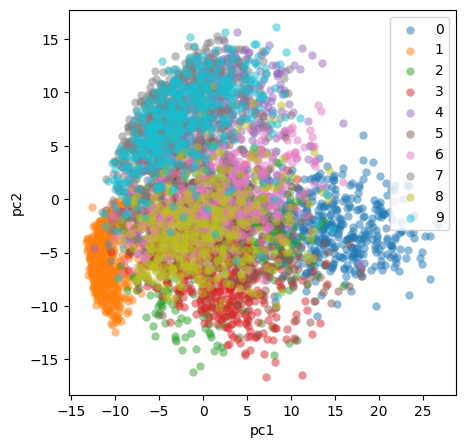

In [6]:
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

pca = PCA(n_components=2).fit_transform(data.numpy())
print(pca.shape)
targets = mnist.targets.numpy()[:5000]
plt.figure(figsize=(5, 5))
for class_idx in range(10):
    idxs = np.argwhere(targets == class_idx)
    plt.scatter(*pca[idxs].T, label=class_idx, lw=0, alpha=0.5)
plt.legend()
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

## Now, let's train a VAE



## First build the model

In [30]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 2)
        ).cuda()

    def forward(self, x):
        h_mu = self.encoder(x)
        return h_mu


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 28 * 28)
        ).cuda()

    def forward(self, x):
        x_hat = self.decoder(x)
        return x_hat

## Complete VAE training step

In [31]:
encoder = Encoder()
decoder = Decoder()


def one_epoch(x, beta, sigma):
    # First get estimated mean from encoder (h_mu)
    # Then sample from N(h_mu, sigma) where sigma will be diagonal matrix to get h
    # Use decoder to reconstruct h to get x_hat
    # Then compute reconstruction and latent distribution loss and return combined loss
    x = x.cuda()
    h_mu = encoder(x)
    h = h_mu + torch.randn_like(h_mu) * sigma
    x_hat = decoder(h)
    reconstruction_loss = F.mse_loss(x, x_hat)
    latent_distrib_loss = (h_mu ** 2).mean()
    loss = reconstruction_loss + beta
    return loss


def train_vae(beta=1e-3, lr=1e-4, epochs=20, sigma=1.0):
    if not encoder or not decoder:
        raise ValueError
    else:
        model = nn.Sequential(encoder, decoder)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        losses = []
        for x in dataloader:
            loss = one_epoch(x, beta, sigma)
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        train_losses.append(np.mean(losses))
        pbar.set_description(f'mse loss: {train_losses[-1]:.4f}')

    model.eval()
    return encoder, decoder, train_losses

encoder, decoder, loss = train_vae()

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Visualize latent space

In [32]:
def visualize_latent_space(encoder, decoder):
    # 2D latent embeddings
    h = []
    for x in dataloader_no_shuffle:
        with torch.no_grad():
            h.append(encoder(x.cuda()).cpu())
    h = torch.cat(h)
    l = h.norm(dim=-1).median().item() * 2.2

    targets = mnist.targets.numpy()[:5000]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

    for class_idx in range(10):
        idxs = np.argwhere(targets == class_idx)
        a = ax0.scatter([], [], label=class_idx)
        ax0.scatter(*h[idxs].T, lw=0, alpha=0.3, c=a.get_facecolor())

    ax0.set_xlim(-l, l)
    ax0.set_ylim(-l, l)
    ax0.legend()
    ax0.grid()
    ax0.set_title('MNIST latent embeddings')

    # Reconstruction over the 2D latent space
    n = 20
    l_ = l - l / n
    h0, h1 = np.meshgrid(np.linspace(-l_, l_, n), -np.linspace(-l_, l_, n))
    h = np.stack((h0, h1), axis=-1).reshape(n * n, 2)
    with torch.no_grad():
        imgs = (decoder(torch.from_numpy(h).float().cuda()) * std + mu).cpu().numpy()
    imgs = np.clip(imgs.reshape((n, n, 28, 28)), 0, 1)
    imgs = np.concatenate(imgs, axis=1)  # (n, 28*n, 28)
    imgs = np.concatenate(imgs, axis=1)  # (28*n, 28*n)
    ax1.imshow(imgs, cmap='gray', extent=(-l, l, -l, l))
    ax1.set_title('Latent space reconstructions')

    plt.tight_layout()
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

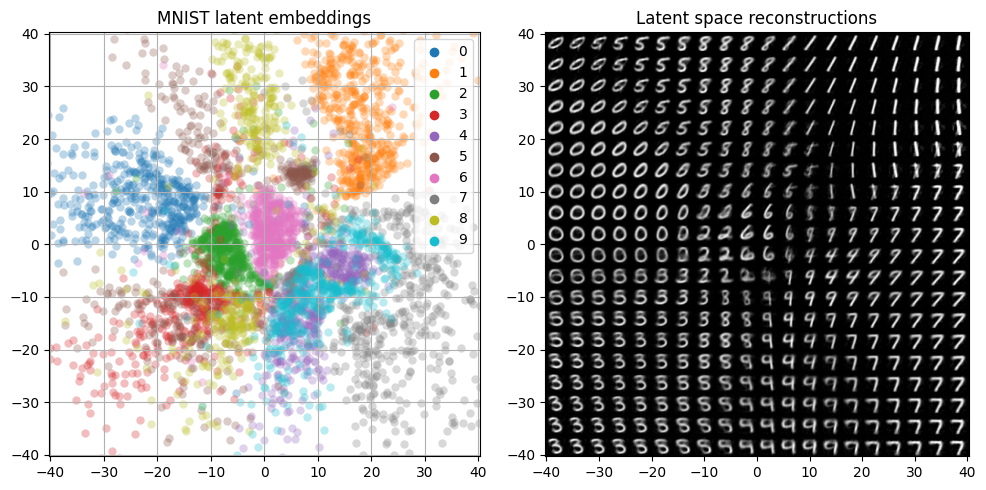

In [33]:
# No latent space prior, no sampling (Standard AE - not VAE)
encoder, decoder, _ = train_vae(beta=0, sigma=0)
visualize_latent_space(encoder, decoder)

  0%|          | 0/20 [00:00<?, ?it/s]

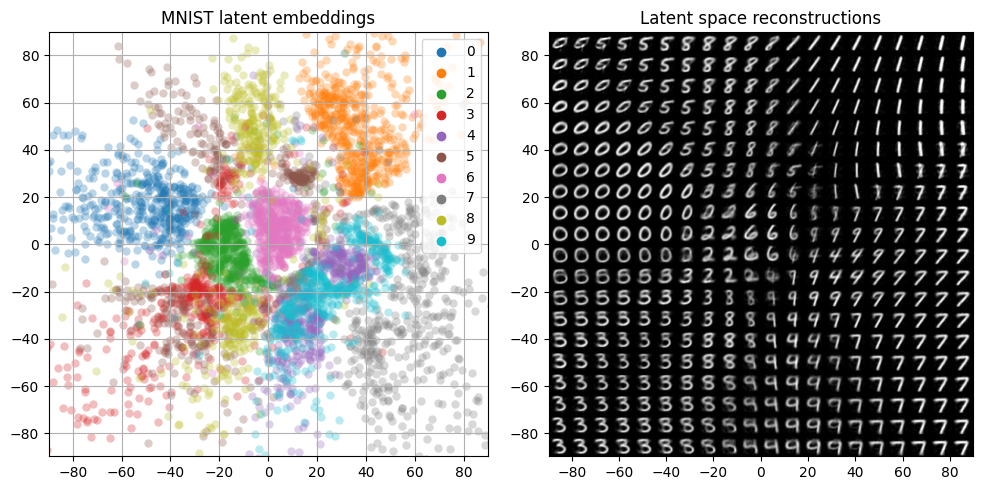

In [35]:
# No latent space prior, but sampling
encoder, decoder, _ = train_vae(beta=0, sigma=1)
visualize_latent_space(encoder, decoder)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


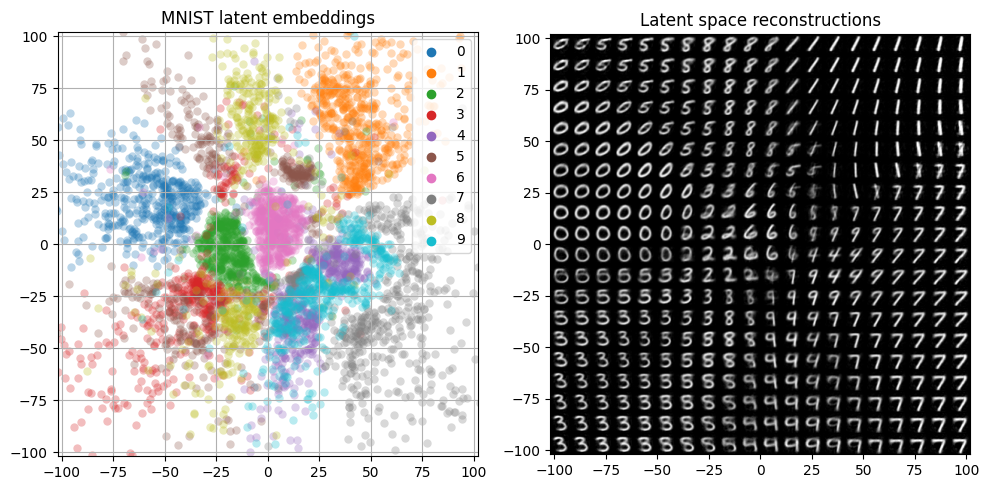

In [36]:
encoder, decoder, _ = train_vae(beta=0.1, sigma=1)
visualize_latent_space(encoder, decoder)